In [1]:
# Imports
import os
import shutil
import matplotlib
import pybullet_envs2

from acme.utils import loggers
from acme.tf import networks
from acme.tf import utils as tf2_utils
from acme.agents.tf.d4pg import D4PG
from acme.agents.tf.ddpg import DDPG
from acme.agents.tf.dmpo import DistributionalMPO
from acme import wrappers, specs, environment_loop

import numpy as np
import sonnet as snt
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# from google.colab import drive
from IPython.display import HTML

from pybullet_envs2.gym_locomotion_envs import HopperBulletEnv
from pybullet_envs2.gym_locomotion_envs import Walker2DBulletEnv
from pybullet_envs2.gym_locomotion_envs import HalfCheetahBulletEnv
from pybullet_envs2.gym_locomotion_envs import AntBulletEnv
from pybullet_envs2.gym_locomotion_envs import HumanoidBulletEnv, HumanoidBulletEnv2

# perfect our own instance of the enviroment is created
# time to manipulate the environments
print(pybullet_envs2.getList())

# @title Figure settings
import ipywidgets as widgets       # interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")


def save_ckpt_to_drive(agent):
  """Saves agent checkpoint directory to Google Drive.

  WARNING: Will replace the entire content of the
  drive directory `/root/drive/MyDrive/acme_ckpt`.

  Args:
    agent: core.Actor
  """
  src = agent._learner._checkpointer._checkpoint_manager.directory
  dst = '/root/drive/MyDrive/acme_ckpt'
  if os.path.exists(dst):
    shutil.rmtree(dst)
  shutil.copytree(src, dst)
  print(f'Saved {src} to {dst}')


def restore_ckpt_from_drive(agent):
  """Restores agent checkpoint directory from Google Drive.

  The name of the local checkpoint directory will be different
  than it was when the checkpoint was originally saved.
  This is because `acme` checkpoiner creates a new directory
  upon restart.

  WARNING: Will replace the entire content of the local
  checkpoint directory (if it exists already).

  Args:
    agent: core.Actor
  """
  src = '/root/drive/MyDrive/acme_ckpt'
  dst = agent._learner._checkpointer._checkpoint_manager.directory
  if os.path.exists(dst):
        shutil.rmtree(dst)
  shutil.copytree(src, dst)
  print(f'Restored {dst} from {src}')
    
def display_video(frames, framerate=30):
  """Generates video from `frames`.

  Args:
    frames (ndarray): Array of shape (n_frames, height, width, 3).
    framerate (int): Frame rate in units of Hz.

  Returns:
    Display object.
  """
  height, width, _ = frames[0].shape
  dpi = 70
  orig_backend = matplotlib.get_backend()
  matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
  fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
  matplotlib.use(orig_backend)  # Switch back to the original backend.
  ax.set_axis_off()
  ax.set_aspect('equal')
  ax.set_position([0, 0, 1, 1])
  im = ax.imshow(frames[0])
  def update(frame):
    im.set_data(frame)
    return [im]
  interval = 1000/framerate
  anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                  interval=interval, blit=True, repeat=False)
  return HTML(anim.to_html5_video())

def make_networks_d4pg(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                       vmin=-150.,
                       vmax=150.,
                       num_atoms=51,
                      ):
  """Networks for D4PG agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes + (action_size,)),
      networks.TanhToSpec(spec=action_spec)
      ])
  critic_network = snt.Sequential([
      networks.CriticMultiplexer(
          action_network=networks.ClipToSpec(action_spec),
          critic_network=networks.LayerNormMLP(
              layer_sizes=critic_layer_sizes,
              activate_final=True),
      ),
      networks.DiscreteValuedHead(vmin=vmin,
                                  vmax=vmax,
                                  num_atoms=num_atoms)
      ])

  return policy_network, critic_network


def make_networks_ddpg(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                      ):
  """Networks for DDPG agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes + (action_size,)),
      networks.TanhToSpec(spec=action_spec)
      ])
  critic_network = networks.CriticMultiplexer(
          action_network=networks.ClipToSpec(action_spec),
          critic_network=networks.LayerNormMLP(
              layer_sizes=critic_layer_sizes + (1,),
              activate_final=False),
              )

  return policy_network, critic_network


def make_networks_dmpo(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                       vmin=-150.,
                       vmax=150.,
                       num_atoms=51,
                      ):
  """Networks for DMPO agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes,
                            activate_final=True),
      networks.MultivariateNormalDiagHead(
          action_size,
          min_scale=1e-6,
          tanh_mean=False,
          init_scale=0.7,
          fixed_scale=False,
          use_tfd_independent=True)
  ])

  # The multiplexer concatenates the (maybe transformed) observations/actions.
  critic_network = networks.CriticMultiplexer(
      action_network=networks.ClipToSpec(action_spec),
      critic_network=networks.LayerNormMLP(layer_sizes=critic_layer_sizes,
                                           activate_final=True),
                                           )
  critic_network = snt.Sequential([
                                   critic_network,
                                   networks.DiscreteValuedHead(vmin=vmin,
                                                               vmax=vmax,
                                                               num_atoms=num_atoms)
                                   ])

  return policy_network, critic_network


class Humanoid2(HumanoidBulletEnv2):

  def __init__(self, render=False, episode_steps=1000):
    """Modifies `__init__` in `HopperBulletEnv` parent class."""
    self.episode_steps = episode_steps
    super().__init__(render=render)

  def reset(self):
    """Modifies `reset` in `WalkerBaseBulletEnv` base class."""
    self.step_counter = 0
    return super().reset()

  def _isDone(self):
    """Modifies `_isDone` in `WalkerBaseBulletEnv` base class."""
    return (self.step_counter == self.episode_steps
            or super()._isDone())

  def step(self, a):
    """Fully overrides `step` in `WalkerBaseBulletEnv` base class."""

    self.step_counter += 1

    # if multiplayer, action first applied to all robots,
    # then global step() called, then _step() for all robots
    # with the same actions
    if not self.scene.multiplayer:
      self.robot.apply_action(a)
      self.scene.global_step()

    state = self.robot.calc_state()  # also calculates self.joints_at_limit

    # state[0] is body height above ground, body_rpy[1] is pitch
    self._alive = float(self.robot.alive_bonus(state[0] + self.robot.initial_z,
                                               self.robot.body_rpy[1]))
    done = self._isDone()
    if not np.isfinite(state).all():
      print("~INF~", state)
      done = True

    potential_old = self.potential
    self.potential = self.robot.calc_potential()
    progress = float(self.potential - potential_old)

    feet_collision_cost = 0.0
    for i, f in enumerate(self.robot.feet):
      contact_ids = set((x[2], x[4]) for x in f.contact_list())
      if (self.ground_ids & contact_ids):
        self.robot.feet_contact[i] = 1.0
      else:
        self.robot.feet_contact[i] = 0.0

    # let's assume we have DC motor with controller, and reverse current braking
    electricity_cost = self.electricity_cost * float(
        np.abs(a * self.robot.joint_speeds).mean())
    electricity_cost += self.stall_torque_cost * float(np.square(a).mean())

    joints_at_limit_cost = float(self.joints_at_limit_cost * self.robot.joints_at_limit)

    self.rewards = [
                    self._alive, progress, electricity_cost,
                    joints_at_limit_cost, feet_collision_cost
                    ]
    self.HUD(state, a, done)
    self.reward += sum(self.rewards)

    return state, sum(self.rewards), bool(done), {}
env = Humanoid2()
env = wrappers.GymWrapper(env)
env = wrappers.SinglePrecisionWrapper(env)
action_spec = env.action_spec()  # Specifies action shape and dimensions.
env_spec = specs.make_environment_spec(env)
print(env.robot.walk_target_x, env.robot.walk_target_y)

['- HumanoidDeepMimicBackflipBulletEnv-v1', '- HumanoidDeepMimicWalkBulletEnv-v1', '- CartPoleBulletEnv-v1', '- CartPoleContinuousBulletEnv-v0', '- MinitaurBulletEnv-v0', '- MinitaurBulletDuckEnv-v0', '- RacecarBulletEnv-v0', '- RacecarZedBulletEnv-v0', '- KukaBulletEnv-v0', '- KukaCamBulletEnv-v0', '- InvertedPendulumBulletEnv-v0', '- InvertedDoublePendulumBulletEnv-v0', '- InvertedPendulumSwingupBulletEnv-v0', '- ReacherBulletEnv-v0', '- PusherBulletEnv-v0', '- ThrowerBulletEnv-v0', '- Walker2DBulletEnv-v0', '- HalfCheetahBulletEnv-v0', '- AntBulletEnv-v0', '- HopperBulletEnv-v0', '- HumanoidBulletEnv-v0', '- HumanoidFlagrunBulletEnv-v0', '- HumanoidFlagrunHarderBulletEnv-v0', '- MinitaurExtendedEnv-v0', '- MinitaurReactiveEnv-v0', '- MinitaurBallGymEnv-v0', '- MinitaurTrottingEnv-v0', '- MinitaurStandGymEnv-v0', '- MinitaurAlternatingLegsEnv-v0', '- MinitaurFourLegStandEnv-v0', '- KukaDiverseObjectGrasping-v0']
1000.0 0


/home/vanillaskies/anaconda3/envs/mne/lib/python3.9/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


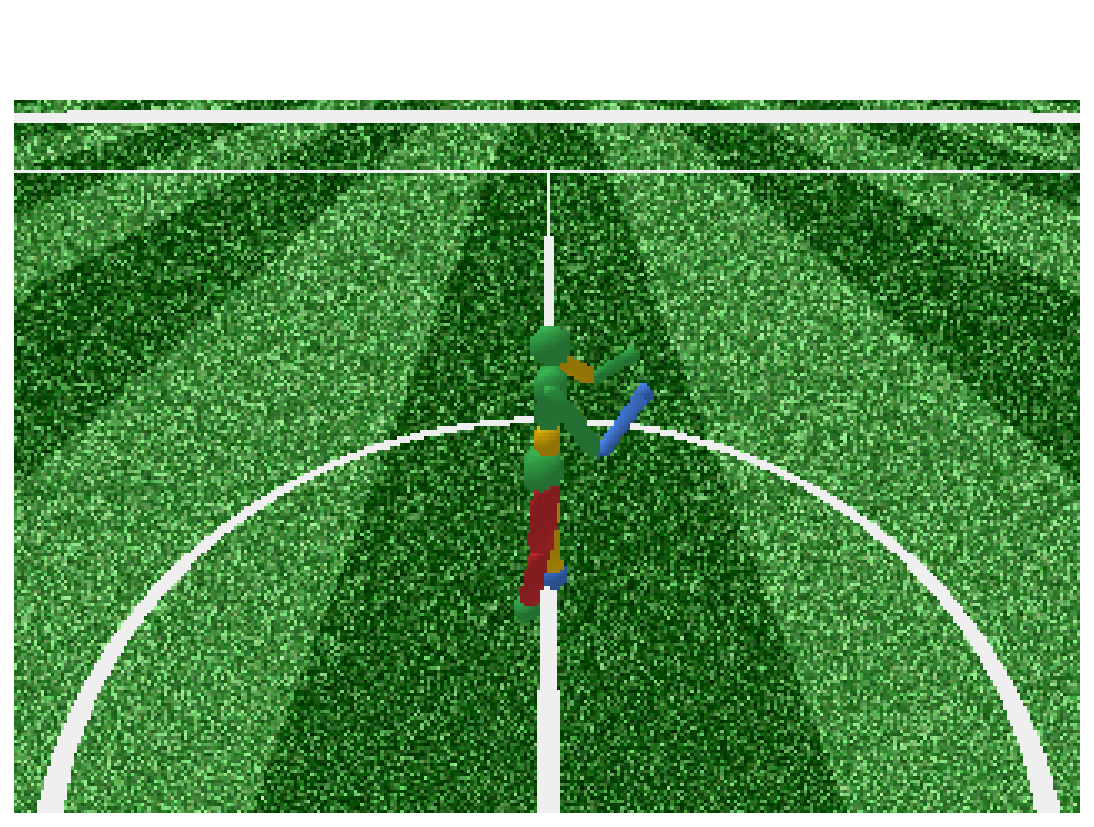

In [2]:
_ = env.reset()

frame = env.environment.render(mode='rgb_array')
plt.imshow(frame)
plt.axis('off')
plt.show()

In [3]:
n_steps = 200

frames = []
timestep = env.reset()
for _ in range(n_steps):
  # Random control of actuators.
  action = np.random.uniform(action_spec.minimum,
                             action_spec.maximum,
                             size=action_spec.shape)
  timestep = env.step(action)
  frames.append(env.environment.render(mode='rgb_array'))

display_video(frames, framerate=20)

In [4]:
print('Actions:\n', env_spec.actions)
print('Observations:\n', env_spec.observations)
print('Rewards:\n', env_spec.rewards)

Actions:
 BoundedArray(shape=(17,), dtype=dtype('float32'), name='action', minimum=[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], maximum=[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.])
Observations:
 BoundedArray(shape=(44,), dtype=dtype('float32'), name='observation', minimum=[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf], maximum=[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf])
Rewards:
 Array(shape=(), dtype=dtype('float32'), name='reward')


In [5]:
for body_part in env.robot.parts.keys():
  print(f"{body_part:10} {env.robot.parts[body_part].pose().xyz()}")

link0_2    [-0.00630951  0.02924766  0.85191518]
torso      [0.01749642 0.03010016 0.91167908]
link0_3    [-0.00630951  0.02924766  0.85191518]
lwaist     [-0.041926    0.01526165  0.79937132]
link0_5    [-0.07780202  0.00107452  0.74705592]
pelvis     [-0.11452509 -0.06675107  0.68033931]
link0_7    [-0.03881435 -0.14406728  0.66330737]
link0_8    [-0.03881435 -0.14406728  0.66330737]
link0_9    [-0.03881435 -0.14406728  0.66330737]
right_thigh [ 0.06450391 -0.18347103  0.53408785]
link0_11   [ 0.19477803 -0.23329771  0.37302901]
right_shin [ 0.06975861 -0.24658389  0.48745638]
right_foot [-0.15086388 -0.27003009  0.68938702]
link0_14   [-0.18321862 -0.0155154   0.61210365]
link0_15   [-0.18321862 -0.0155154   0.61210365]
link0_16   [-0.18321862 -0.0155154   0.61210365]
left_thigh [-0.02203205  0.03813705  0.60402259]
link0_18   [0.17948689 0.10652717 0.59368307]
left_shin  [0.27878828 0.11857291 0.45622712]
left_foot  [0.454026   0.13983008 0.21365783]
link0_21   [ 0.0528221  -0.1311

In [6]:
env.robot_body.speed()

array([ 0.01901643, -0.15590134, -2.66471305])

In [7]:
learner_log_every = 60.  # Learner logging frequency, seconds.
loop_log_every = 60.  # Environment loop logging frequency, seconds.
checkpoint = True  # Checkpoint saved every 10 minutes.

learner_logger = loggers.TerminalLogger(label='Learner',
                                        time_delta=learner_log_every,
                                        print_fn=print)
loop_logger = loggers.TerminalLogger(label='Environment Loop',
                                     time_delta=loop_log_every,
                                     print_fn=print)

# Note: optimizers can be passed only to the D4PG and DMPO agents.
# The optimizer for DDPG is hard-coded in the agent class.
policy_optimizer = snt.optimizers.Adam(1e-4)
critic_optimizer = snt.optimizers.Adam(1e-4)

In [8]:
# Create networks.
policy_network, critic_network = make_networks_d4pg(action_spec)

# Create agent.
agent = D4PG(environment_spec=env_spec,
             policy_network=policy_network,
             critic_network=critic_network,
             observation_network=tf2_utils.batch_concat, # Identity Op.
             policy_optimizer=policy_optimizer,
             critic_optimizer=critic_optimizer,
             logger=learner_logger,
             checkpoint=checkpoint)

In [ ]:
num_steps = 1000000 # 100_000  # Number of environment loop steps. Adjust as needed!

loop = environment_loop.EnvironmentLoop(env, agent, logger=loop_logger)

# Start training!
loop.run(num_episodes=None,
         num_steps=num_steps)

[Environment Loop] Episode Length = 17 | Episode Return = -8.688192367553711 | Episodes = 1 | Steps = 17 | Steps Per Second = 24.879


INFO:tensorflow:Assets written to: /home/vanillaskies/acme/14036cbe-fc55-11eb-8105-28d244c7acc5/snapshots/policy/assets


INFO:tensorflow:Assets written to: /home/vanillaskies/acme/14036cbe-fc55-11eb-8105-28d244c7acc5/snapshots/policy/assets


INFO:tensorflow:Assets written to: /home/vanillaskies/acme/14036cbe-fc55-11eb-8105-28d244c7acc5/snapshots/critic/assets


INFO:tensorflow:Assets written to: /home/vanillaskies/acme/14036cbe-fc55-11eb-8105-28d244c7acc5/snapshots/critic/assets


[Learner] Critic Loss = 3.942 | Policy Loss = 0.500 | Steps = 1 | Walltime = 0
[Environment Loop] Episode Length = 21 | Episode Return = -42.60932159423828 | Episodes = 306 | Steps = 5426 | Steps Per Second = 93.945
[Learner] Critic Loss = 1.829 | Policy Loss = 0.406 | Steps = 733 | Walltime = 61.253
[Environment Loop] Episode Length = 18 | Episode Return = -35.10435104370117 | Episodes = 576 | Steps = 11055 | Steps Per Second = 107.148
[Learner] Critic Loss = 1.514 | Policy Loss = 0.419 | Steps = 1428 | Walltime = 121.308
[Environment Loop] Episode Length = 27 | Episode Return = 10.065975189208984 | Episodes = 825 | Steps = 16241 | Steps Per Second = 81.431
[Learner] Critic Loss = 1.474 | Policy Loss = 0.413 | Steps = 2062 | Walltime = 181.342
[Environment Loop] Episode Length = 35 | Episode Return = 3.6387782096862793 | Episodes = 992 | Steps = 22052 | Steps Per Second = 103.844
[Learner] Critic Loss = 1.642 | Policy Loss = 0.458 | Steps = 2803 | Walltime = 241.420
[Environment Loop]

INFO:tensorflow:Assets written to: /home/vanillaskies/acme/14036cbe-fc55-11eb-8105-28d244c7acc5/snapshots/policy/assets


INFO:tensorflow:Assets written to: /home/vanillaskies/acme/14036cbe-fc55-11eb-8105-28d244c7acc5/snapshots/critic/assets


INFO:tensorflow:Assets written to: /home/vanillaskies/acme/14036cbe-fc55-11eb-8105-28d244c7acc5/snapshots/critic/assets


[Learner] Critic Loss = 1.731 | Policy Loss = 0.458 | Steps = 21809 | Walltime = 1802.609
[Environment Loop] Episode Length = 49 | Episode Return = 43.40928268432617 | Episodes = 3765 | Steps = 180862 | Steps Per Second = 98.432
[Learner] Critic Loss = 1.728 | Policy Loss = 0.458 | Steps = 22554 | Walltime = 1862.669
[Environment Loop] Episode Length = 68 | Episode Return = 69.69811248779297 | Episodes = 3852 | Steps = 186879 | Steps Per Second = 102.130
[Learner] Critic Loss = 1.708 | Policy Loss = 0.450 | Steps = 23302 | Walltime = 1922.717
[Environment Loop] Episode Length = 69 | Episode Return = 83.37150573730469 | Episodes = 3935 | Steps = 192911 | Steps Per Second = 104.388
[Learner] Critic Loss = 1.772 | Policy Loss = 0.464 | Steps = 24049 | Walltime = 1982.749
[Environment Loop] Episode Length = 77 | Episode Return = 25.346782684326172 | Episodes = 4018 | Steps = 198953 | Steps Per Second = 92.526
[Learner] Critic Loss = 1.744 | Policy Loss = 0.475 | Steps = 24798 | Walltime = 

[Learner] Critic Loss = 1.741 | Policy Loss = 0.454 | Steps = 29262 | Walltime = 2403.065
[Environment Loop] Episode Length = 59 | Episode Return = 72.10539245605469 | Episodes = 4597 | Steps = 240905 | Steps Per Second = 96.739
[Learner] Critic Loss = 1.783 | Policy Loss = 0.457 | Steps = 30010 | Walltime = 2463.131
[Environment Loop] Episode Length = 80 | Episode Return = 94.75980377197266 | Episodes = 4683 | Steps = 247013 | Steps Per Second = 98.860
[Learner] Critic Loss = 1.821 | Policy Loss = 0.465 | Steps = 30765 | Walltime = 2523.205
[Environment Loop] Episode Length = 60 | Episode Return = 42.79024124145508 | Episodes = 4774 | Steps = 252995 | Steps Per Second = 97.541
[Learner] Critic Loss = 2.121 | Policy Loss = 0.460 | Steps = 31512 | Walltime = 2583.240
[Environment Loop] Episode Length = 98 | Episode Return = 3.9566378593444824 | Episodes = 4860 | Steps = 259016 | Steps Per Second = 95.742
[Learner] Critic Loss = 1.951 | Policy Loss = 0.455 | Steps = 32260 | Walltime = 26

[Learner] Critic Loss = 1.705 | Policy Loss = 0.445 | Steps = 36758 | Walltime = 3003.480
[Environment Loop] Episode Length = 55 | Episode Return = 18.654563903808594 | Episodes = 5298 | Steps = 295286 | Steps Per Second = 98.907
[Learner] Critic Loss = 1.789 | Policy Loss = 0.453 | Steps = 37502 | Walltime = 3063.500
[Environment Loop] Episode Length = 81 | Episode Return = 77.18611145019531 | Episodes = 5375 | Steps = 301259 | Steps Per Second = 100.759
[Learner] Critic Loss = 1.732 | Policy Loss = 0.441 | Steps = 38253 | Walltime = 3123.521
[Environment Loop] Episode Length = 80 | Episode Return = 39.5726318359375 | Episodes = 5444 | Steps = 307288 | Steps Per Second = 99.759
[Learner] Critic Loss = 1.663 | Policy Loss = 0.439 | Steps = 39002 | Walltime = 3183.595
[Environment Loop] Episode Length = 69 | Episode Return = 66.81182098388672 | Episodes = 5523 | Steps = 313307 | Steps Per Second = 97.263
[Learner] Critic Loss = 1.666 | Policy Loss = 0.433 | Steps = 39753 | Walltime = 32

INFO:tensorflow:Assets written to: /home/vanillaskies/acme/14036cbe-fc55-11eb-8105-28d244c7acc5/snapshots/policy/assets


INFO:tensorflow:Assets written to: /home/vanillaskies/acme/14036cbe-fc55-11eb-8105-28d244c7acc5/snapshots/critic/assets


INFO:tensorflow:Assets written to: /home/vanillaskies/acme/14036cbe-fc55-11eb-8105-28d244c7acc5/snapshots/critic/assets


[Learner] Critic Loss = 1.698 | Policy Loss = 0.441 | Steps = 44240 | Walltime = 3603.869
[Environment Loop] Episode Length = 83 | Episode Return = 82.16790008544922 | Episodes = 6011 | Steps = 355554 | Steps Per Second = 97.908
[Learner] Critic Loss = 1.751 | Policy Loss = 0.444 | Steps = 44944 | Walltime = 3663.898
[Environment Loop] Episode Length = 130 | Episode Return = 144.66139221191406 | Episodes = 6070 | Steps = 361196 | Steps Per Second = 100.436
[Learner] Critic Loss = 1.756 | Policy Loss = 0.444 | Steps = 45694 | Walltime = 3723.900
[Environment Loop] Episode Length = 75 | Episode Return = 30.907672882080078 | Episodes = 6134 | Steps = 367220 | Steps Per Second = 103.048
[Learner] Critic Loss = 1.842 | Policy Loss = 0.457 | Steps = 46440 | Walltime = 3783.921
[Environment Loop] Episode Length = 83 | Episode Return = 35.1116943359375 | Episodes = 6200 | Steps = 373246 | Steps Per Second = 101.625
[Learner] Critic Loss = 1.769 | Policy Loss = 0.447 | Steps = 47191 | Walltime 

INFO:tensorflow:Assets written to: /home/vanillaskies/acme/14036cbe-fc55-11eb-8105-28d244c7acc5/snapshots/policy/assets


INFO:tensorflow:Assets written to: /home/vanillaskies/acme/14036cbe-fc55-11eb-8105-28d244c7acc5/snapshots/critic/assets


INFO:tensorflow:Assets written to: /home/vanillaskies/acme/14036cbe-fc55-11eb-8105-28d244c7acc5/snapshots/critic/assets


[Learner] Critic Loss = 1.771 | Policy Loss = 0.443 | Steps = 66387 | Walltime = 5404.934
[Environment Loop] Episode Length = 140 | Episode Return = 144.71273803710938 | Episodes = 7750 | Steps = 534473 | Steps Per Second = 80.476
[Learner] Critic Loss = 1.750 | Policy Loss = 0.432 | Steps = 67065 | Walltime = 5465.004
[Environment Loop] Episode Length = 80 | Episode Return = 90.23661041259766 | Episodes = 7799 | Steps = 540146 | Steps Per Second = 100.399
[Learner] Critic Loss = 1.734 | Policy Loss = 0.442 | Steps = 67814 | Walltime = 5525.078
[Environment Loop] Episode Length = 87 | Episode Return = 104.30753326416016 | Episodes = 7853 | Steps = 546176 | Steps Per Second = 99.709
[Learner] Critic Loss = 1.764 | Policy Loss = 0.436 | Steps = 68552 | Walltime = 5585.124
[Environment Loop] Episode Length = 65 | Episode Return = 90.5872802734375 | Episodes = 7900 | Steps = 551956 | Steps Per Second = 96.883
[Learner] Critic Loss = 1.740 | Policy Loss = 0.431 | Steps = 69232 | Walltime = 

INFO:tensorflow:Assets written to: /home/vanillaskies/acme/14036cbe-fc55-11eb-8105-28d244c7acc5/snapshots/policy/assets


INFO:tensorflow:Assets written to: /home/vanillaskies/acme/14036cbe-fc55-11eb-8105-28d244c7acc5/snapshots/critic/assets


INFO:tensorflow:Assets written to: /home/vanillaskies/acme/14036cbe-fc55-11eb-8105-28d244c7acc5/snapshots/critic/assets


[Learner] Critic Loss = 1.789 | Policy Loss = 0.434 | Steps = 87781 | Walltime = 7208.534
[Environment Loop] Episode Length = 472 | Episode Return = 426.97540283203125 | Episodes = 8997 | Steps = 708455 | Steps Per Second = 100.476
[Learner] Critic Loss = 1.910 | Policy Loss = 0.451 | Steps = 88530 | Walltime = 7269.396
[Environment Loop] Episode Length = 69 | Episode Return = 62.0632438659668 | Episodes = 9026 | Steps = 714523 | Steps Per Second = 98.198
[Learner] Critic Loss = 1.861 | Policy Loss = 0.436 | Steps = 89285 | Walltime = 7329.467
[Environment Loop] Episode Length = 1000 | Episode Return = 917.4725341796875 | Episodes = 9052 | Steps = 720575 | Steps Per Second = 100.695
[Learner] Critic Loss = 1.877 | Policy Loss = 0.434 | Steps = 90022 | Walltime = 7389.537
[Environment Loop] Episode Length = 187 | Episode Return = 181.82095336914062 | Episodes = 9085 | Steps = 726586 | Steps Per Second = 100.038
[Learner] Critic Loss = 1.913 | Policy Loss = 0.446 | Steps = 90772 | Wallti

In [ ]:
env_step = 0
for episode in reward:
  plt.plot(np.arange(env_step, env_step+len(episode)), episode)
  env_step += len(episode)
plt.xlabel('Timestep', fontsize=14)
plt.ylabel('Reward', fontsize=14)
plt.grid()
plt.show()

In [ ]:
for i, episode in enumerate(reward):
  print(f"Total reward in episode {i}: {sum(episode):.2f}")

In [ ]:
# Run the environment with the learned policy and display video.
n_steps = 500

frames = []  # Frames for video.
reward = [[]]  # Reward at every timestep.
timestep = env.reset()
for _ in range(n_steps):
  frames.append(env.environment.render(mode='rgb_array').copy())
  action = agent.select_action(timestep.observation)
  timestep = env.step(action)

  # `timestep.reward` is None when episode terminates.
  if timestep.reward:
    # Old episode continues.
    reward[-1].append(timestep.reward.item())
  else:
    # New episode begins.
    reward.append([])

display_video(frames)